## 目的

train.csv の情報（年代別、target別、等々）と紐づけたmatersials.csv, techniques.csvの分析を行います。

## もくじ

### 0. 下準備
### 1. matersials.csv について
### 2. techniques.csv について

読んでて長ったらしかったので、初回アップロード時よりだいぶ削りましたm(_ _)m

## 0. 下準備

In [1]:
# ライブラリインポート
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from PIL import Image
import glob

In [5]:
# pandas データフレーム 読み込み
DATA_DIR = 'dataset_atmaCup11'

train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
mate_df = pd.read_csv(os.path.join(DATA_DIR, 'materials.csv'))
tech_df = pd.read_csv(os.path.join(DATA_DIR, 'techniques.csv'))

In [6]:
print('train num: ', len(train_df), '\tmaterials num: ', len(mate_df), '\ttechniques num: ', len(tech_df))

train num:  3937 	materials num:  9081 	techniques num:  3777


[nndropout1 さん のディスカッション([EDA]コンペのデータへの理解を深めましょう！)](https://www.guruguru.science/competitions/17/discussions/c91c9c19-a907-4de9-89aa-294542758590/) で述べられています通り、

* materials.csv には train.csv の 1作品(60c1cacb453d497ad3a4.jpg) が存在しない。
* techniques.csv には train.csv の 1371作品 が存在しない。
* materials.csv、techniques.csv　それぞれには、ひとつの作品('object_id')に対して複数の材料、技法('name')が対応している。

という注意点がございます。

## 1. matersials.csv について

年代ごとの材料の使用具合の推移を調べます。

materials.csv の 'name' 列に対して one-hotエンコーディング + 'object_id' 内で足し合わせます。

In [7]:
one_hot_mate = pd.get_dummies(mate_df, columns=['name'])
one_hot_mate = one_hot_mate.set_index('object_id')
one_hot_mate = one_hot_mate.sum(level=0).reset_index()

# 余分な列名削除
new_name = {}
for name in one_hot_mate:
    new_name[name] = name.replace('name_', '')

one_hot_mate = one_hot_mate.rename(columns=new_name)

one_hot_mate.head()

,object_id,India ink (ink),bristol board,cardboard,chalk,deck paint,gold leaf,gouache (paint),graphite (mineral),ink,...,paper,parchment (animal material),pencil,prepared paper,tracing paper,varnish,velvet (fabric weave),watercolor (paint),wood (plant material),zinc
0,002bff09b09998d0be65,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
1,00309fb1ef05416f9c1f,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,003a1562e97f79ba96dc,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
3,004890880e8e7431147b,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,00718c32602425f504c1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


そうしましたら、train.csvとone-hotで表現されたmaterials.csvを紐づけて分析していきます。

In [8]:
unit_mate_df = train_df.merge(one_hot_mate, on='object_id', how='left')
unit_mate_df.head()

,object_id,sorting_date,art_series_id,target,India ink (ink),bristol board,cardboard,chalk,deck paint,gold leaf,...,paper,parchment (animal material),pencil,prepared paper,tracing paper,varnish,velvet (fabric weave),watercolor (paint),wood (plant material),zinc
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'target'(年代)ごとでグループ分けした各材料の使用具合の推移を見てみます。

見やすくするために、絶対数が少ない(num < 10)
 * tracing paper
 * linen (material)
 * India ink (ink)
 * leather
 * wood (plant material)
 * velvet (fabric weave)
 * palm leaf (material)
 * metal, zinc, varnish
 * gold leaf
 * bristol board
 
 は削除しちゃいます。

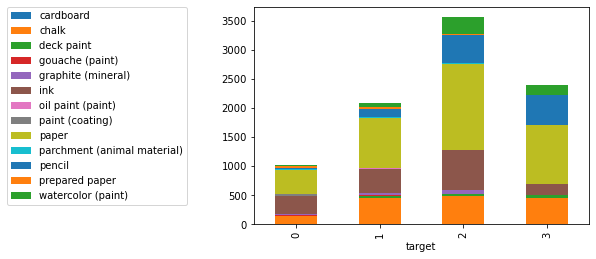

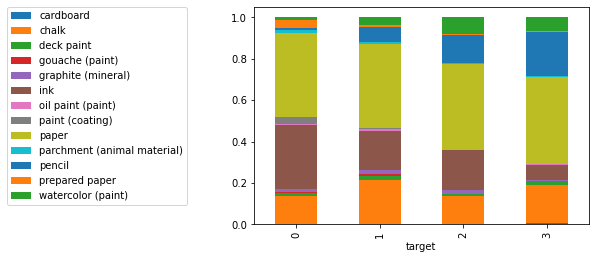

In [9]:
# 全部みるときはこちら
#grouped_unit_df = unit_mate_df.drop('object_id', axis=1).drop('sorting_date', axis=1).drop('art_series_id', axis=1).groupby('target').sum()

drop_list = ['tracing paper', 'linen (material)', 'India ink (ink)', 'leather', 'wood (plant material)', 'velvet (fabric weave)', 'palm leaf (material)', 'metal', 'zinc', 'varnish', 'gold leaf', 'bristol board']
grouped_unit_df = unit_mate_df.drop('object_id', axis=1).drop('sorting_date', axis=1).drop('art_series_id', axis=1)

# 削除
for drop in drop_list:
    grouped_unit_df = grouped_unit_df.drop(drop, axis=1)

grouped_unit_df = grouped_unit_df.groupby('target').sum()

grouped_unit_df.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right', borderaxespad=0, fontsize=10)

grouped_unit_df.div(grouped_unit_df.sum(axis=1), axis=0).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right', borderaxespad=0, fontsize=10)

上図は、'target'(年代別)でのサンプル数の推移、下図は、'target'(年代別)での使用割合の推移を表します。凡例が棒グラフのスタックする順番と逆に表示されていますので注意してください。

下図を眺めた感じですと、
* paper は一概によく使用されている。
* pencil, watercolor (paint) は年代を経るごとに使用具合が増えていく。
* ink は年代を経るごとに使用具合が減っていく。

このへんの材料が特徴量としてキーになってくるんですかね！(wkwk) また、'target' ですと「世紀ごと」という大きなくくりで分割されてしまっていますので、50年ごとで分割して使用具合の遷移を見るのも面白いかもしれませんね。

## techniques.csv について

つぎに、年代ごとの技法の使用具合の推移を調べます。

techniques.csv の 'name' 列に対して one-hotエンコーディング + 'object_id' 内で足し合わせます。

In [10]:
one_hot_tech = pd.get_dummies(tech_df, columns=['name'])
one_hot_tech = one_hot_tech.set_index('object_id')
one_hot_tech = one_hot_tech.sum(level=0).reset_index()

# 余分な列名削除
new_name = {}
for name in one_hot_tech:
    new_name[name] = name.replace('name_', '')

one_hot_tech = one_hot_tech.rename(columns=new_name)
one_hot_tech.head()

,object_id,brush,chalk,counterproof,engraving,letterpress printing,pen,pencil,scoring,sewing,snipping
0,002bff09b09998d0be65,0,0,0,0,0,1,0,0,0,0
1,00309fb1ef05416f9c1f,1,0,0,0,0,0,0,0,0,0
2,004890880e8e7431147b,0,0,1,0,0,0,0,0,0,0
3,007f5e3620b458d77212,1,0,0,0,0,0,0,0,0,0
4,00bf812ffe8a62d45661,1,0,0,0,0,1,0,0,0,0


そうしましたら、train.csvとone-hotで表現されたtechniques.csvを紐づけて分析していきます。

In [11]:
unit_tech_df = train_df.merge(one_hot_tech, on='object_id', how='left')
unit_tech_df.head()

,object_id,sorting_date,art_series_id,target,brush,chalk,counterproof,engraving,letterpress printing,pen,pencil,scoring,sewing,snipping
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


'target'(年代)ごとでグループ分けした各技法の使用具合の推移を見てみます。

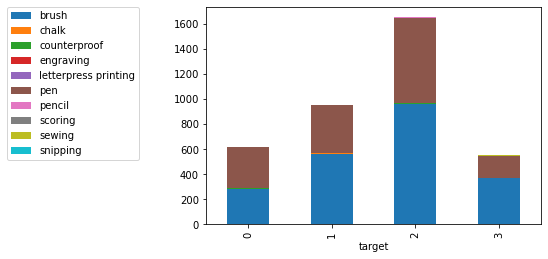

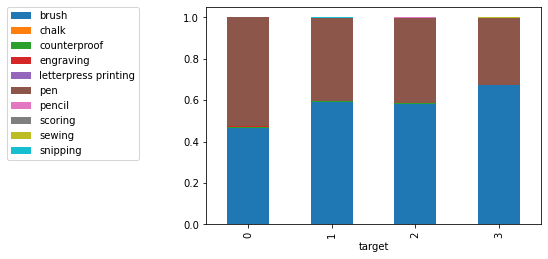

In [12]:
grouped_unit_df = unit_tech_df.drop('object_id', axis=1).drop('sorting_date', axis=1).drop('art_series_id', axis=1).groupby('target').sum()

grouped_unit_df.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right', borderaxespad=0, fontsize=10)

grouped_unit_df.div(grouped_unit_df.sum(axis=1), axis=0).plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(-0.2, 1), loc='upper right', borderaxespad=0, fontsize=10)

こちらも同様に上図は、'target'(年代別)でのサンプル数の推移、下図は、'target'(年代別)での使用割合の推移を表します。凡例が棒グラフのスタックする順番と逆に表示されていますので注意してください。

下図を眺めた感じですと、

* ほとんどの技法が brush, pen。
* brush は年代を経るごとに使用割合が増えていく。
* pen は年代を経るごとに使用割合が減っていく。

技法に関してはほぼbrush, penなんですね！